# Data Preparation

## Download Data from Kaggle

In [ ]:
with open('kaggle.json', 'w') as f:
    f.write('{"username":"amilarn","key":"asdasdjasdhasdksalşdşasd"}')
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!rm -r sample_data
!kaggle competitions download -c dataset_name
!unzip dataset_name.zip -d .
!rm dataset_name.zip kaggle.json

## Prepare Data with Categorical as One-Hot Encoded and Fill NaN Values

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
class DataPrep(object):
    def __init__(self, df, y):
        self.df = df.copy()
        self.y = y.copy()
        self.n_data = df.shape[0]
        self.arrs = []
        self.cols = []
        self.nans = []
        self.prepared_df = None

    def search_nan(self):
        for i in self.df:
            for j in self.df[i]:
                if j != j:
                    self.nans.append(i)
                    break

    def pca(self, k, change_inner = False):
        if self.prepared_df is not None:
            X = self.prepared_df
            # Mean center the data
            X = X - np.mean(X, axis=0)

            # Calculate the covariance matrix
            cov = np.cov(X, rowvar=False)

            # Calculate the eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eig(cov)

            # Sort the eigenvalues and corresponding eigenvectors from largest
            # to smallest eigenvalue and select the top k eigenvectors
            idx = eigenvalues.argsort()[::-1]
            eigenvalues = eigenvalues[idx][:k]
            eigenvectors = eigenvectors[:, idx][:, :k]
            if k > self.prepared_df.shape[1]:
                print('Ignoring k and using', self.prepared_df.shape[1])
            # Project the data onto the eigenvectors
            X_transformed = X @ eigenvectors
            if change_inner:
                self.prepared_df = X_transformed
            return X_transformed

        else:
            print('Run prepare() first!!!')

    def train_test_split(self, test_size=0.15, val_size=0.15):
        if self.prepared_df is not None:
            n_train = int(self.n_data*(1 - test_size - val_size))
            n_test = int(self.n_data*(test_size))
            n_val = self.n_data - n_train - n_test
            arr_data = self.prepared_df.to_numpy()
            arr_y = self.y
            np.random.seed(31)
            p = np.random.permutation(len(self.y))
            arr_data = arr_data[p]
            arr_y = arr_y[p]
            if val_size == 0:
                return arr_data[:n_train], arr_y[:n_train], arr_data[n_train:], arr_y[n_train:]
            else:
                return arr_data[:n_train], arr_y[:n_train], arr_data[n_train:n_train+n_val], arr_y[n_train:n_train+n_val], arr_data[n_train+n_val:], arr_y[n_train+n_val:]
        else:
            print("Run prepare() first!!!")

    def fill_categorical_nan_and_one_hot_encode(self, col):
        arr = self.df[col].to_numpy()
        dct = dict()
        nan_ind = []

        for i in range(len(arr)):
            element = arr[i]
            if isinstance(element, str) and element != 'nan':
                try:
                    dct[element] += 1
                except:
                    dct[element] = 1
            else:
                nan_ind.append(i)

        nonnan_len = len(arr) - len(nan_ind)
        for i in dct:
            dct[i] = dct[i]/nonnan_len
        for i in nan_ind:
            # arr[i] = np.random.choice(list(dct.keys()), p=list(dct.values()))
            arr[i] = "nan"
        freq_arr = np.zeros(len(dct.keys()))
        uni_vals = np.unique(arr).tolist()
        uni_vals.remove("nan")
        encoded_arr = np.zeros((self.n_data, len(uni_vals)))
        encod_dict = dict()
        for i in range(len(uni_vals)):
            encod_dict[uni_vals[i]] = i
        for i in range(len(freq_arr)):
            freq_arr[i] = dct[uni_vals[i]]
        for i in range(self.n_data):
            if arr[i] == "nan":
                encoded_arr[i] = freq_arr.copy()
            else:
                encoded_arr[i][encod_dict[arr[i]]] = 1
        return encoded_arr, encod_dict

    def fill_numerical_nan(self, col):
        return self.df[col].fillna(self.df[col].mean())

    def one_hot_encode_not_nan(self, col):
        arr = self.df[col].to_numpy()
        dct = dict()

        for i in range(len(arr)):
            element = arr[i]
            try:
                dct[element] += 1
            except:
                dct[element] = 1

        uni_vals = np.unique(arr).tolist()
        encoded_arr = np.zeros((self.n_data, len(uni_vals)))
        encod_dict = dict()
        for i in range(len(uni_vals)):
            encod_dict[uni_vals[i]] = i
        for i in range(self.n_data):
            encoded_arr[i][encod_dict[arr[i]]] = 1
        return encoded_arr, encod_dict

    def normalize_numerical(self, arr):
        return (arr - arr.mean())/arr.std()

    def prepare(self):
        d_types = self.df.dtypes
        self.search_nan()
        for i in self.df:
            if i in self.nans:
                if d_types[i] == "object":
                    ret_tuple = self.fill_categorical_nan_and_one_hot_encode(i)
                    for k in ret_tuple[0].T:
                        self.arrs.append(k)
                    for j in ret_tuple[1]:
                        self.cols.append(i+'_'+j)
                else:
                    self.arrs.append(self.normalize_numerical(self.fill_numerical_nan(i)))
                    self.cols.append(i)
            else:
                if d_types[i] == "object":
                    ret_tuple = self.one_hot_encode_not_nan(i)
                    for k in ret_tuple[0].T:
                        self.arrs.append(k)
                    for j in ret_tuple[1]:
                        self.cols.append(i+'_'+j)
                else:
                    self.arrs.append(self.normalize_numerical(self.df[i]))
                    self.cols.append(i)
        self.prepared_df = pd.DataFrame(np.array(self.arrs).T, columns=self.cols)
        return pd.DataFrame(np.array(self.arrs).T, columns=self.cols), self.y


In [ ]:
label_name = "HasDetections"
id_col = "MachineIdentifier"
train_file = "train.csv"

df = pd.read_csv(train_file)
y = df[label_name].values
ids = df[id_col].values
df.drop([label_name, id_col], axis=1, inplace=True)
preparator = DataPrep(df, y)
PreparedData, labels = preparator.prepare()
X_train, y_train, X_val, y_val, X_test, y_test = preparator.train_test_split(0.10, 0.20)
n_data, n_features = PreparedData.shape[0:2]
X = X_train
y = y_train
print("%d data available with %d features (some are one hot encoded)"%(n_data, n_features))
print("%d, %d, %d"%(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('train.csv')
y = df["Habitability_score"].values
ids = df['Property_ID'].values
df.drop(['Habitability_score', 'Property_ID'], axis=1, inplace=True)
preparator = DataPrep(df, y)
PreparedData, labels = preparator.prepare()

In [ ]:
preparator.pca(50, True)

Ignoring k and using 31


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-1.015751,-0.596085,0.738126,-0.178739,-0.193791,0.695765,-0.850833,0.412109,-0.472348,-0.261667,...,0.009588,-0.002424,0.012598,-0.006924,-8.077239e-16,1.900617e-16,7.257781e-17,-3.297792e-16,-2.315568e-16,-3.836474e-16
1,-1.003138,0.441814,1.356306,0.034143,-0.539035,-0.235087,0.728013,-1.004309,-0.692895,-0.079566,...,0.022914,-0.007606,0.013287,-0.001106,-5.471046e-16,4.369211e-16,1.496756e-15,-5.301579e-16,-6.924401e-16,1.290524e-15
2,-0.367215,-0.433299,-0.511807,-0.252913,0.249412,0.064136,-0.995059,-0.575381,-0.124146,-0.228682,...,0.000299,-0.001071,0.016434,0.004306,-7.837112e-16,3.551414e-16,-1.053447e-15,1.124804e-16,-3.698598e-16,-6.812745e-16
3,-1.272696,3.509279,0.260212,0.018272,0.143976,-0.103587,-0.368831,-0.754387,-0.056292,1.204123,...,0.046924,-0.001176,-0.014438,-0.049305,4.357969e-17,4.872211e-16,4.884338e-16,-9.348942e-16,-7.013783e-16,1.808074e-15
4,4.743813,-0.656853,0.578215,-2.059588,-0.140851,0.531316,0.732353,-0.474150,0.138161,-0.317655,...,0.001049,-0.000106,0.008024,0.010387,-8.532334e-16,6.402580e-16,-1.576406e-16,4.242521e-16,1.086034e-15,-8.980270e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39494,-0.337044,-0.271514,0.928860,0.163623,-0.123858,-0.180294,-0.599312,0.144599,0.551107,-0.506477,...,0.029834,-0.016770,-0.002739,-0.015390,-5.785635e-16,8.461045e-16,-3.584790e-16,1.745997e-16,9.629957e-16,-5.993104e-17
39495,-0.942272,1.121944,0.750267,-0.341819,0.044766,-1.146305,0.057909,-0.360174,0.640248,-0.433718,...,0.026594,-0.016675,0.000695,-0.016589,-6.664542e-16,9.722437e-16,-7.203554e-16,1.043238e-16,1.192021e-15,-4.576738e-16
39496,3.116358,0.031622,-0.500277,-0.518624,0.067224,-1.664007,-0.085863,-0.731213,-0.055062,1.179604,...,0.086241,-0.046028,0.043540,-0.014569,-1.093203e-16,4.646404e-16,4.687212e-16,-9.267683e-17,-1.248139e-15,1.154903e-15
39497,-0.856041,0.024503,1.380354,0.554246,-0.791760,0.386273,-0.993346,0.410864,-0.738455,-0.252100,...,0.035162,-0.019955,0.001791,-0.013182,-6.657002e-16,5.222809e-16,6.071920e-16,-9.494274e-16,5.462252e-16,-2.327410e-16


#EDA Analysis

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
1,0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
2,0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
3,0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
4,0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70


In [ ]:
#Data Description

df.info()
df.describe()

In [ ]:
#number of NaN values
df.isnull().sum()

Property_ID                  0
Property_Type                0
Property_Area                0
Number_of_Windows         1654
Number_of_Doors              0
Furnishing                1042
Frequency_of_Powercuts    1383
Power_Backup                 0
Water_Supply                 0
Traffic_Density_Score        0
Crime_Rate                 787
Dust_and_Noise            1219
Air_Quality_Index            0
Neighborhood_Review          0
Habitability_score           0
dtype: int64

In [ ]:
PreparedData['Habitability_score'] = labels

In [ ]:
corr = PreparedData.corr()

In [ ]:
#Correlation Heat Map
import seaborn as sns
sns.clustermap(corr, annot=True, fmt='.2f', cmap='coolwarm', figsize=(25, 25))

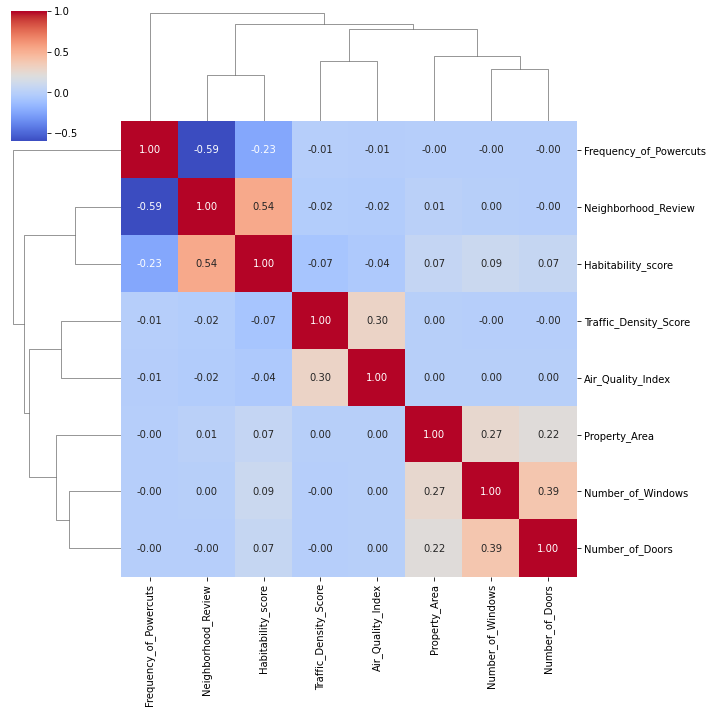

In [ ]:
sns.clustermap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, fmt='.2f', cmap='coolwarm')


In [ ]:
df.select_dtypes(include=['float64', 'int64', 'int', 'float']).corr()

,Property_Area,Number_of_Windows,Number_of_Doors,Frequency_of_Powercuts,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review
0,106,NaN,1,0.0,5.89,90.0,3.86
1,733,2.0,2,1.0,4.37,96.0,3.55
2,737,4.0,2,0.0,7.45,121.0,3.81
3,900,3.0,2,2.0,6.16,100.0,1.34
4,2238,14.0,6,0.0,5.46,116.0,4.77
...,...,...,...,...,...,...,...
39494,1120,3.0,2,0.0,5.55,80.0,3.56
39495,445,1.0,3,1.0,5.70,86.0,2.93
39496,3780,6.0,6,0.0,6.84,137.0,3.80
39497,1266,3.0,1,0.0,4.60,88.0,3.25


# Linear Regression Model

In [ ]:
# class Xavier(object):
#     def __init__(self):
#         pass

#     def initialize(self, weights_shape, fan_in, fan_out):
#         sigma = np.sqrt(2./(fan_out+fan_in))
#         return np.random.randn(*weights_shape) * sigma

## Using Gradient Descent

In [ ]:
class Linear_Regression_GD():

    def __init__(self,features, ground_truth_y, learning_rate):                     #f-->nxm(n samples, m features)
        self.weights = np.random.randn(features.shape[1]+1,1)  #w-->(m+1)x1
        #self.weights = Xavier().initialize([features.shape[1]+1,1], features.shape[0]*(features.shape[1]+1), features.shape[1]+1 )
        bias = np.ones(features.shape[0], dtype=int)  #bias-->1xn
        self.features = np.insert(features, 0, bias, axis=1)  #f-->nx(m+1)
        self.ground_truth_y = ground_truth_y[:, np.newaxis]
        self.learning_rate = learning_rate
        self.loss_list = list()
        self.n = ground_truth_y.shape[0]

    def Fitting(self):
        self.fitted_y = np.dot(self.features, self.weights)

    def Loss(self):
        #self.loss = (1/(2*self.n))*(np.sum(np.square(self.fitted_y - self.ground_truth_y)))
        self.loss = (1/(2*self.n))*np.dot((self.fitted_y - self.ground_truth_y).T, self.fitted_y - self.ground_truth_y)
        return self.loss

    def Loss_Derivative(self):
        self.dfitted_y = (1/self.n)*(self.fitted_y-self.ground_truth_y).T
        self.dweights = np.dot(self.dfitted_y, self.features).T

    def Gradient_Descent(self):
        self.weights = self.weights - self.learning_rate * self.dweights

    def Train(self, n_epochs, X_val = None, y_val = None):
        if X_val is not None:
            valloss_list = list()
            bias = np.ones(X_val.shape[0], dtype=int)
            X_val = np.insert(X_val, 0, bias, axis=1)
            val = True
        for epoch in range(n_epochs):
            self.Fitting()
            self.Loss_Derivative()
            self.Gradient_Descent()
            loss = self.Loss()
            if val:
                  valloss = self.Test(X_val, y_val)
                  valloss_list.append(valloss)

            self.loss_list.append(loss)
            if epoch % 100 == 0:
                print('Epoch: %d \tLoss: %.4f\tval_loss: %.4f'%(epoch, loss, valloss))

        if val:
            return self.loss_list, valloss_list
        return self.loss_list

    def Test(self, X, y):
        n = X.shape[0]
        y_hat = np.dot(X, self.weights)[:,0]
        loss = (1/(2*n))*np.dot((y_hat - y).T, (y_hat - y))
        return loss



In [ ]:
import matplotlib.pyplot as plt

model2 = Linear_Regression_GD(X,y,0.05)
epoch = 1000
losses, val_losses = model2.Train(epoch, X_test, y_test)
plt.plot(np.arange(epoch), np.squeeze(losses) )
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('Train ')
plt.show()
plt.plot(np.arange(epoch), np.squeeze(val_losses) )
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('Test ')

## Using Mean Squared Error

In [ ]:
class Linear_Regression_MSE(object):
    def __init__(self, features, ground_truth_y):                     #f-->nxm(n samples, m features)
        bias = np.ones((len(features),), dtype=int)              #bias-->1xn
        self.features = np.insert(features, 0, bias, axis=1)    #f-->nx(m+1)
        self.ground_truth_y = ground_truth_y
        self.num_features = features.shape[1]

    def Optimize_Weights(self):
        z = np.dot(self.features.T, self.features)
        import sys
        if np.linalg.det(z) < 1e-10:
            print("Determinant is near zero!")
            return
        if np.linalg.cond(z) > 1/sys.float_info.epsilon:
            print("Nearly Singular Matrix using PINV!")
            self.a = np.linalg.pinv(z) # Moore-Penrose pseudoinverse is used!
        else:
            self.a = np.linalg.inv(z)
        self.b = np.dot(self.a, self.features.T)
        self.weights = np.dot(self.b, self.ground_truth_y)            #w-->(m+1)x1


    def Predict(self):
        self.fitted_y = np.dot(self.features, self.weights)
        return self.fitted_y

    def Calculate_Loss(self):
        self.n = self.ground_truth_y.shape[0]
        print(self.fitted_y.shape, self.ground_truth_y.shape)
        self.loss = (1/(2*self.n))*(np.sum(np.square(self.fitted_y - self.ground_truth_y)))
        return self.loss


In [ ]:
model = Linear_Regression_MSE(X, y)
model.Optimize_Weights()
model.Predict()
print(model.Calculate_Loss())

(27649,) (27649,)
40.167104199545825


In [ ]:
mat2 = model.features.T @ model.features
print(np.trace(mat2))
mat = mat2 + 1 * np.eye(*(mat.shape))
np.linalg.matrix_rank(mat), mat.shape, np.trace(mat)

386303.41621618706


(32, (32, 32), 386335.41621618706)

In [ ]:
import sys
np.linalg.cond(mat2), 1/sys.float_info.epsilon

(1.833267144796295e+17, 4503599627370496.0)

In [ ]:
np.linalg.det([[1,2,3], [5,2,0], [0,0,0]])

0.0

In [ ]:
class DecisionTreeRegressor:
    def __init__(self):
        self.tree = None

    def best_split(X, y):
    best_gain = 0
    best_feature = 0
    best_threshold = 0

    for feature in range(X.shape[1]):
        for threshold in X[:, feature]:
            # Calculate the gain from splitting on this feature and threshold
            gain = calculate_gain(X, y, feature, threshold)

            # Update the best split if this split is better
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold, best_gain


  def create_tree(X, y):
    # Calculate the best split at this node
    feature, threshold, gain = best_split(X, y)

    # Create a new node with the best split
    node = {'feature': feature, 'threshold': threshold}

    # Split the data into left and right branches based on the best split
    left_indices = X[:, feature] < threshold
    right_indices = X[:, feature] >= threshold
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]

    # Recursively create the left and right branches
    node['left'] = create_tree(X_left, y_left)
    node['right'] = create_tree(X_right, y_right)

    return node

    # Fit the model to the training data
    def fit(self, X, y):
        self.tree = self.create_tree(X, y)

    # Make predictions using the tree
    def predict(self, X):
        # ...

In [ ]:
import numpy as np

class Decision_Tree_Regression(object):
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_samples_split and depth <= self.max_depth:
            best_idx, best_threshold = self._best_criteria(X, y)
            left_idx, right_idx = self._split(X[:, best_idx], best_threshold)
            left = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
            right = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
            return Node(best_idx, best_threshold, left, right)
        leaf_value = self._leaf_value(y)
        return Node(value=leaf_value)

    def _best_criteria(self, X, y):
        num_features = np.shape(X)[1]
        best_idx, best_threshold = None, None
        min_impurity = float('inf')
        for idx in range(num_features):
            thresholds = np.unique(X[:, idx])
            for threshold in thresholds:
                impurity = self._impurity(y, threshold, X[:, idx])
                if impurity <= min_impurity:
                    min_impurity = impurity
                    best_idx = idx
                    best_threshold = threshold
        return best_idx, best_threshold

    def _impurity(self, y, threshold, feature):
        left_idx, right_idx = self._split(feature, threshold)
        if len(left_idx) == 0 or len(right_idx) == 0:
            return float('inf')
        left = y[left_idx]
        right = y[right_idx]
        p = len(left) / len(y)
        impurity = p * self._gini(left) + (1 - p) * self._gini(right)
        return impurity

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return 1 - np.sum(np.square(p))

    def _split(self, feature, threshold):
        left_idx = np.argwhere(feature <= threshold).flatten()
        right_idx = np.argwhere(feature > threshold).flatten()
        return left_idx, right_idx

    def _leaf_value(self, y):
        leaf_value = np.mean(y)
        return leaf_value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        feature_value = x[node.idx]
        if feature_value <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

class Node(object):
    def __init__(self, idx=None, threshold=None, left=None, right=None, value=None):
        self.idx = idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def __repr__(self):
        return "Node(idx={}, threshold={}, value={})".format(self.idx, self.threshold, self.value)

    def __str__(self):
        return self.__repr__()

# Path: Decision_Tree_Regression.ipynb
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

net = Decision_Tree_Regression()
net.fit(X_train, y_train)
y_pred = net.predict(X_test)
mean_squared_error(y_pred, y_test)

62.39378667317984